# Детекция транспортных средств с помощью YOLOv8 в условиях ограниченной освещенности

## Вводная часть:

**Информация об авторе:**

Меня зовут Артем Мусиенко, я специализируюсь на глубоком обучении (**Deep Learning**). Заканчиваю обучение на курсе **THE FOUNDER** “Разработчик нейросетей”.

**Аннотация:**

Современный мир уже трудно представить без камер видеонаблюдения. Такие камеры уже оснащены детекцией автомобилей, номерных знаков и так далее. Не всегда получаются качественные изображения транспортных средств, что приводит к сложностям детекции в связи с ограниченной освещенностью. Для решения подобных задачи можно использовать модели **YOLO** от компании **Ultralytics**. Из семейства этих моделей была выбрана **8** версия. Почему? Она сочетает в себе зрелость экосистемы **Ultralytics** и современную архитектуру, эта модель обладает расширенными возможностями по сравнению с предшественниками, а именно: сегментация экземпляров, оценка позы/ключевых точек и классификация.

## Установка и импорт библиотек:

Выполним установку необходимых библиотек. Флаг `-q` ставится для вывода меньшей информации во время установки:

In [ ]:
!pip install ultralytics kaggle ipywidgets kagglehub albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.1 MB/s eta 0:00:00


Выполним импорт всех необходимых библиотек. При первой работе с **Google Drive** в **Google Colab** произойдет переадресация на другую страницу, в которой будет разделы с пользовательским соглашением и предоставлением доступа к файлам в **Google Drive**, с которыми нужно согласиться, чтобы код смог успешно интегрировать функцию сохранения модели на диск:

In [ ]:
import os
import random
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Индикатор выполнения кода
from google.colab import files, drive
from IPython.display import clear_output
from ultralytics import YOLO
import ipywidgets as widgets # Для создания виджетов
import kagglehub # Для скачивания датасета
import json
import albumentations as A # Аугментация
import yaml # Для создания собственного файла формата .yaml
from PIL import Image
import shutil

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


> Также при выполнении основной части кода будем использовать **графический ускоритель T4**. По желанию можно использовать ускоритель мощнее, но так как я пользуюсь бесплатной версией **Google Colab**, то для меня доступен только **T4**.

## Теоретическая часть:

### Основная проблема:

Перед написанием основной части кода стоит ознакомиться с теоретической частью данной темы.

Какая главная проблема стоит перед нами? Качество детекции с ранними версиями модели не всегда достигает высоких значений, но с моделью **YOLOv8** мы попробуем улучшить этот результат. Для сравнения можно взглянуть на график, который опубликовала компания **Ultralytics**:
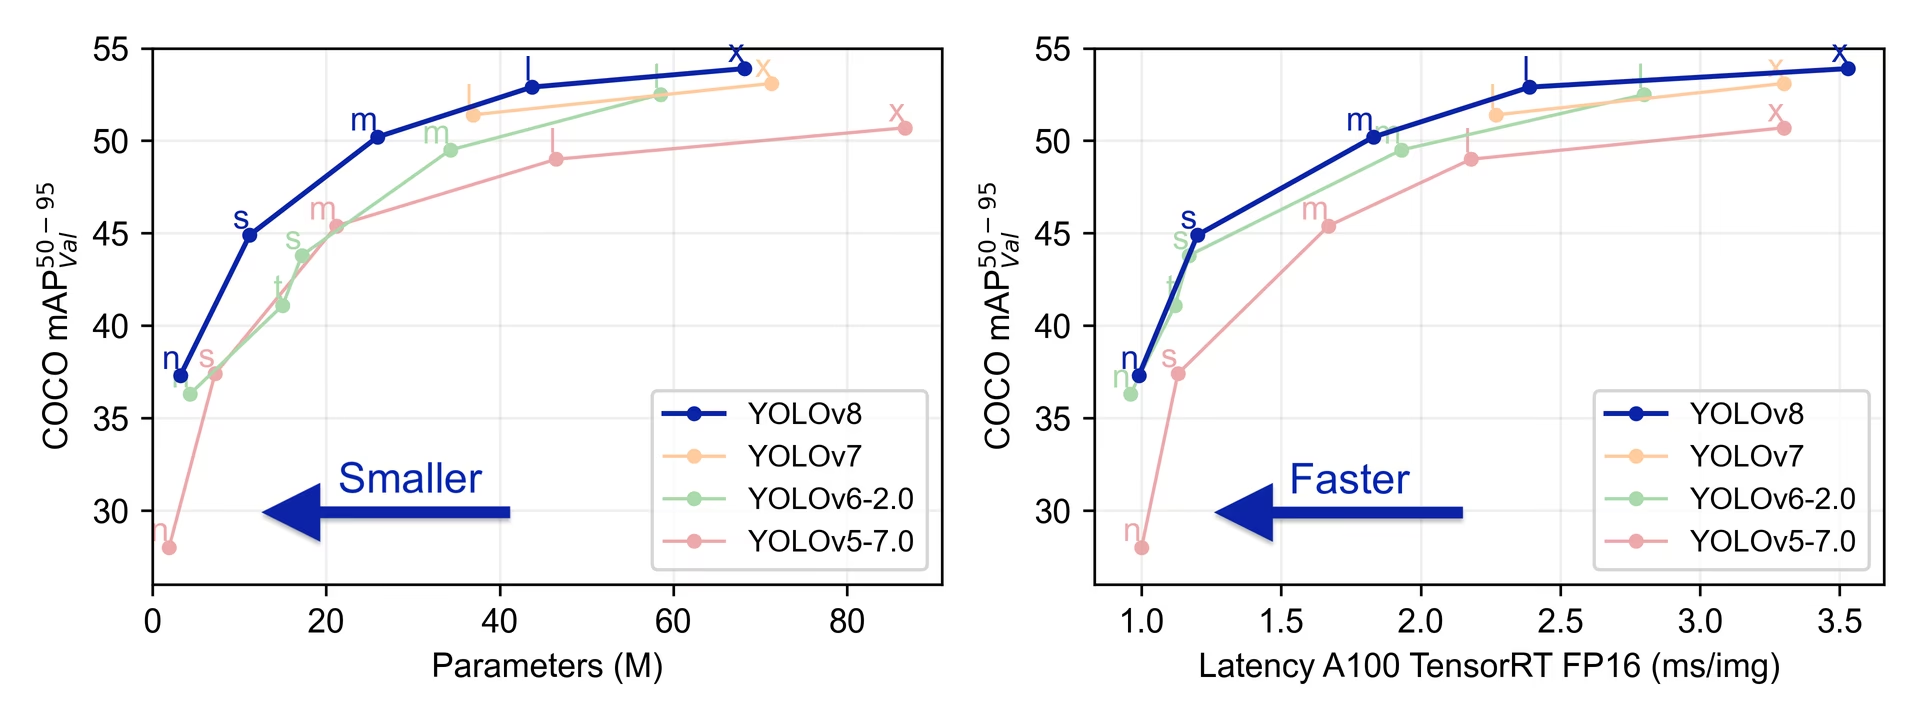

### Основные концепции и математическое обоснование:

Теперь перейдем к основным концепциям. В отличие от моделей, которые анализируют изображение в несколько проходов, **YOLO** делает предсказания за один проход через нейронную сеть. Это обеспечивает высокую скорость, что критично для приложений реального времени (например, автономные автомобили, видеонаблюдение). Изображение делится на сетку. Для каждой ячейки сетки модель предсказывает:
*   **Bounding Box**: Координаты центра, ширину и высоту рамки объекта;
*   **Класс объекта**: Вероятность принадлежности к каждому из обучаемых классов (например, "человек", "автомобиль");
*   **Уверенность (Confidence Score)**: Насколько модель уверена, что в этой ячейке вообще есть объект.

Используется комбинированная функция потерь, которая одновременно оптимизирует:
*   **Localization Loss**: Точность координат bounding box. Данная функция потерь сравнивает предсказанную моделью рамку с настоящей (разметкой);
*   **Classification Loss**: Правильность определения класса. Штрафует модель, если она: уверена, что объект есть, а на самом деле его нет (**False Positive**) и не уверена, что объект есть, а на самом деле он есть (**False Negative**);
*   **Objectness Loss**: Уверенность в наличии объекта. Штрафует за неверное определение класса.

Модель во время обучения постоянно пытается минимизировать эту общую сумму штрафов. Градиентный спуск показывает ей направление, в котором нужно скорректировать веса, чтобы в следующий раз сумма штрафов была меньше.

После получения множества перекрывающихся **bounding box**, **NMS** оставляет только самые "уверенные" из них, убирая дубликаты. Это позволяет получить чистый финальный результат с одной рамкой для каждого объекта.

Также в YOLOv8 отказались от использования "якорей"

### Архитектура:

Также затроним архитектуру **YOLOv8**. **YOLOv8** использует трёхкомпонентную архитектуру:

*   **Backbone** — извлекает признаки из изображения (основан на **CSPDarknet**);
*   **Neck** — объединяет признаки разных масштабов (**FPN** + **PAN**);
*   **Head** — предсказывает bounding box’ы и классы (**anchor-free**).

## Подготовка данных:

Перейдем к скачиванию датасета. В качества датасета будет использоваться [Cars Detection](https://www.kaggle.com/datasets/abdallahwagih/cars-detection/data). Для того, чтобы его скачать, нам потребуется зарегистрироваться на **Kaggle** и получить свой *API-ключ* через настройки профиля.

После получения вашего *API-ключа* от **Kaggle** перейдем к написанию небольшого интерфейса для ввода `username` и `key`. Для этого будем использоваться виджеты.

Далее перейдем к функции `download_data_on_click`. Именно в ней происходит скачивание датасета, вывод его структуры для нагляднсоти, а также осуществлены дополнительные проверки.

In [ ]:
DATASET_DIR = ''

username_widget = widgets.Text(
    description='Kaggle Username:',
    placeholder='Ваш_логин_kaggle',
    style={'description_width': 'initial'}
)

key_widget = widgets.Password(
    description='Kaggle Key (API):',
    placeholder='Ваш_ключ_kaggle',
    style={'description_width': 'initial'}
)

download_button = widgets.Button(
    description='Скачать датасет',
    button_style='success',
    icon='download'
)

# Виджет для вывода логов
output_widget = widgets.Output()

def download_data_on_click(b):
    global DATASET_DIR

    with output_widget:
        clear_output()
        # Получаем значения из виджетов ввода
        username = username_widget.value
        key = key_widget.value

        if not username or not key:
            print("Ошибка: Имя пользователя и ключ не могут быть пустыми.")
            return

        try:
            # Создаем kaggle.json
            kaggle_dir = os.path.expanduser('~/.kaggle')
            kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
            os.makedirs(kaggle_dir, exist_ok=True)

            # Формируем JSON с учетными данными для Kaggle API
            json_content = json.dumps({"username": username, "key": key})
            with open(kaggle_json_path, 'w') as f:
                f.write(json_content)

            !chmod 600 {kaggle_json_path} # Устанавливаем права доступа к файлу

            print(f"Файл 'kaggle.json' успешно создан в {kaggle_json_path}")
            print("Аутентификация Kaggle прошла успешно ✅")

            DATASET_DIR = kagglehub.dataset_download("abdallahwagih/cars-detection") # Скачиваем выбранный датасет

            print(f"\nДатасет успешно загружен и распакован в:")
            print(DATASET_DIR)

            # Проверка структуры датасета
            train_img_dir = os.path.join(DATASET_DIR, './Cars Detection/train/images')
            val_img_dir = os.path.join(DATASET_DIR, './Cars Detection/valid/images')

            if not os.path.exists(train_img_dir):
                raise FileNotFoundError(f"Папка 'train/images' не найдена. Проверьте: {train_img_dir}")
            if not os.path.exists(val_img_dir):
                raise FileNotFoundError(f"Папка 'valid/images' не найдена. Проверьте: {val_img_dir}")

            print("Структура датасета верна ✅")

            # Выводим структуру датасета для отладки
            print("\Структура датасета:")
            for root, dirs, files in os.walk(DATASET_DIR):
                level = root.replace(DATASET_DIR, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")

        except Exception as e:
            print(f"\n⛔ Ошибка: {e}")

# Связываем кнопку с функцией
download_button.on_click(download_data_on_click)

# Отображаем все виджеты
display(username_widget, key_widget, download_button, output_widget)

Text(value='', description='Kaggle Username:', placeholder='Ваш_логин_kaggle', style=DescriptionStyle(descript…

Password(description='Kaggle Key (API):', placeholder='Ваш_ключ_kaggle', style=DescriptionStyle(description_wi…

Button(button_style='success', description='Скачать датасет', icon='download', style=ButtonStyle())

Output()

Исходя из содержимого датасета можно увидеть его структуру. Данные в нем уже поделены на обучающие (train), валидационные (valid) и тестовые (test) выборки.

Стоит упомянуть такой термин, как **аугментация данных**. Это техника искусственного расширения обучающей выборки путем применения случайных преобразований к исходным изображениям. В нашем коде она используется для улучшения обучения модели **YOLO** детекции транспортных средств. Аугментация помогает модели стать более устойчивой к различным условиям: изменениям освещения, погоды, углов обзора и других факторов. Это предотвращает переобучение и повышает точность детекции на реальных данных, с которыми модель столкнется при эксплуатации.

Реализуем аугментацию для случайного изображения из обучающего набора данных. Выведем оригинальный и аугментированный варианты изображений, а также узнаем путь расположения изображения:

Путь к изображению: /kaggle/input/cars-detection/Cars Detection/train/images/c6f32b8a12b9a44a_jpg.rf.15aaace0b3b4714b6d0fe3148807d9f8.jpg


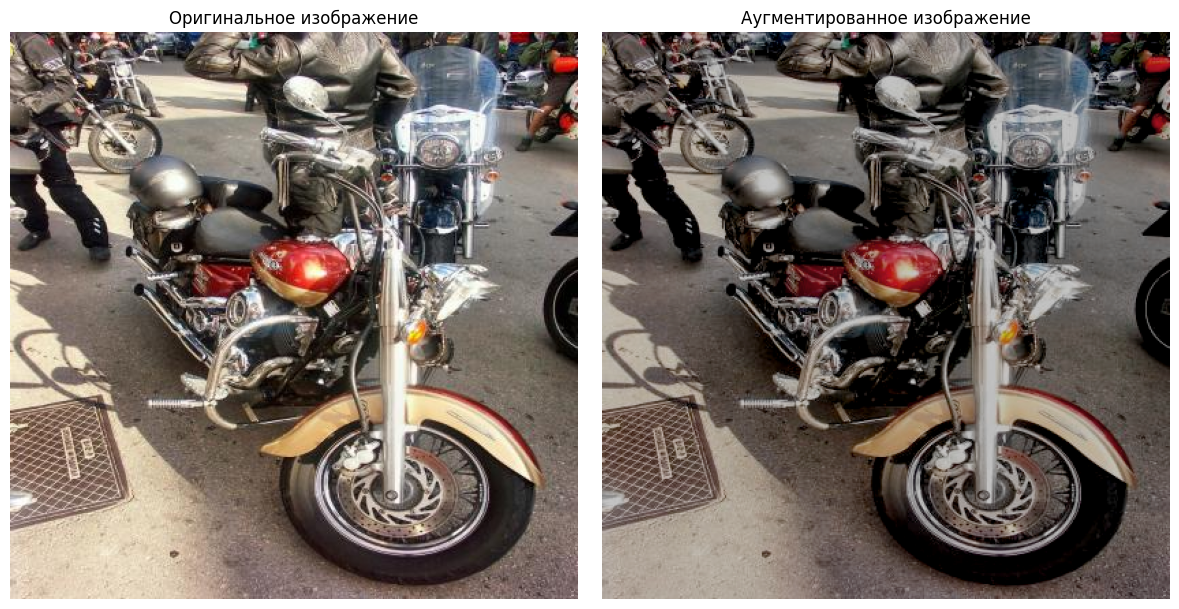

In [ ]:
# Получаем путь к папке с обучающими изображениями
train_img_dir = os.path.join(DATASET_DIR, 'Cars Detection/train/images')

# Получаем список всех изображений
image_files = glob.glob(os.path.join(train_img_dir, "*.jpg"))

if image_files:
    # Выбираем случайное изображение
    random_image = random.choice(image_files)
    print(f"Путь к изображению: {random_image}")

    # Загружаем изображение для аугментации
    image = cv2.imread(random_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертируем в RGB

    # Определяем параметры аугментации без bbox_params
    transform_visualization = A.Compose([
        A.HorizontalFlip(p=0.5), # Зеркальное отражение
        A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.1), contrast_limit=(-0.2, -0.1), p=1), # Умеренное затемнение
        A.Rotate(limit=15, p=0.5), # Поворот до 15 градусов
        A.GaussianBlur(blur_limit=2, p=0.4),  # Легкое размытие до 2px
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=(-20, -5), val_shift_limit=(-15, -5), p=1), # Слабые цветовые сдвиги
        A.RandomGamma(gamma_limit=(70, 90), p=0.6), # Умеренное затемнение через гамма-коррекцию
        A.ChannelShuffle(p=0.1), # Случайное перемешивание каналов
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2), # Легкая дымка/туман
    ])

    # Применяем аугментации
    augmented = transform_visualization(image=image)
    augmented_image = augmented['image']

    # Создаем фигуру для сравнения
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Оригинальное изображение
    axes[0].imshow(image)
    axes[0].set_title('Оригинальное изображение')
    axes[0].axis('off')

    # Аугментированное изображение
    axes[1].imshow(augmented_image)
    axes[1].set_title('Аугментированное изображение')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("В папке train/images не найдены изображения!")

Инициализируем переменные с путями к исходным данным к изображениям и аннотациям, которые в дальнейшем потребуются для создания аугментированной версии датасета:

In [ ]:
# Пути к исходным данным
images_path = os.path.join(DATASET_DIR, "Cars Detection/train/images/")
annotations_path = os.path.join(DATASET_DIR, "Cars Detection/train/labels/")

Создадим отдельную папку для аугментированных данных и наладим новые пути для дальнейшей работы с аугментацией:

In [ ]:
# Новая папка для аугментированных данных - используем рабочую директорию Kaggle
base_augmented_path = "/kaggle/working/Cars Detection Augmentation/"

# Создаем финальные пути
train_images_path = os.path.join(base_augmented_path, "train/images/")
train_labels_path = os.path.join(base_augmented_path, "train/labels/")
valid_images_path = os.path.join(base_augmented_path, "valid/images/")
valid_labels_path = os.path.join(base_augmented_path, "valid/labels/")

Создадим финальные папки для аугментированных данных:

In [ ]:
# Создаем папки для сохранения аугментированных данных
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(valid_images_path, exist_ok=True)
os.makedirs(valid_labels_path, exist_ok=True)

Создадим список всех файлов изображений (jpg/jpeg) в папке с исходными данными для последующей аугментации:

In [ ]:
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.jpeg')]

Функция `load_annotation` загружает и обрабатывает файл аннотаций. Она проверяет существование файла по указанному пути, затем читает его построчно. Каждая строка файла содержит данные об одном объекте: идентификатор класса и нормализованные координаты **bounding box** в порядке **x_center**, **y_center**, **width**, **height**. Функция преобразует текстовые значения в числа, сохраняя координаты как числа с плавающей точкой, а идентификатор класса как целое число. Результатом работы являются два списка: **boxes** с координатами всех объектов и **class_labels** с соответствующими идентификаторами классов:

In [ ]:
# Функция для загрузки и обработки аннотаций
def load_annotation(file_path):
    boxes = []
    class_labels = []
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                boxes.append([x_center, y_center, width, height])
                class_labels.append(int(class_id))
    return boxes, class_labels

Следующая функция сохраняет аннотации в файл, записывая для каждого объекта идентификатор класса и координаты **bounding box** с точностью до шести знаков после запятой. Она создает или перезаписывает файл по указанному пути, формируя строки в соответствии со стандартом YOLO:

In [ ]:
# Функция для сохранения аннотаций в формате YOLO
def save_annotation(file_path, boxes, class_labels):
    with open(file_path, 'w') as f:
        for box, class_id in zip(boxes, class_labels):
            f.write(f"{class_id} {box[0]:.6f} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f}\n")

Эта функция преобразует имя файла изображения в соответствующее имя файла аннотации, заменяя расширение на .txt:

In [ ]:
# Функция для получения имени файла аннотации
def get_label_filename(image_filename):
    return os.path.splitext(image_filename)[0] + '.txt'

Эта функция фильтрует **bounding boxes**, оставляя только валидные. Она проверяет, что координаты центров находятся в диапазоне [0,1], размеры положительные и не превышают 1, а также что ширина и высота больше 1% от размера изображения, отсеивая слишком мелкие или некорректные **bbox** после аугментации:

In [ ]:
# Функция для проверки валидности bounding boxes
def validate_bboxes(boxes, image_shape):
    valid_boxes = []
    for box in boxes:
        x_center, y_center, width, height = box
        # Проверяем что координаты в пределах [0,1] и размеры положительные
        if (0 <= x_center <= 1 and 0 <= y_center <= 1 and
            0 < width <= 1 and 0 < height <= 1 and
            width > 0.01 and height > 0.01):  # Минимальный размер bbox
            valid_boxes.append(box)
    return valid_boxes

Теперь определим параметры аугментации с **bbox_params**. Принципиальное отличие от предыдущих настроек аугментации в том, что здесь гарантируется при всех трансформациях **bounding boxes** остаются корректными, синхронизированными с изображением и не теряют свои метки классов:

In [ ]:
transform_augmentation  = A.Compose([
        A.HorizontalFlip(p=0.5), # Зеркальное отражение
        A.RandomBrightnessContrast(brightness_limit=(-0.5, -0.3), contrast_limit=(-0.3, -0.1), p=1), # Затемнение и снижение контраста
        A.Rotate(limit=15, p=0.5), # Поворот до 15°
        A.GaussianBlur(blur_limit=3, p=0.3),  # Размытие до 3px
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=(-30, -15), val_shift_limit=(-20, -10), p=1), # Изменение цветов
        A.RandomGamma(gamma_limit=(40, 80), p=0.5), # Затемнение через гамма-коррекцию
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

Следующий код выполняет основной процесс аугментации данных: он последовательно обрабатывает каждое изображение, применяя к нему и соответствующим **bounding boxes** трансформации для имитации плохих условий освещения. После аугментации каждое изображение случайным образом распределяется в тренировочную (80%) или валидационную (20%) выборку, сохраняется вместе с обновленными аннотациями и ведется подсчет итогового количества файлов в каждой категории.

Также для ясности и дополнительной визуализации добавим индикатор выполнения кода для аугментации, применив `tqdm`:

In [ ]:
# Аугментация изображений и аннотаций
print("Начинаем аугментацию данных...")
train_files = []
val_files = []

for image_file in tqdm(image_files):
    image_path = os.path.join(images_path, image_file)
    annotation_path = os.path.join(annotations_path, get_label_filename(image_file))

    # Загружаем изображение и аннотацию
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes, class_labels = load_annotation(annotation_path)

    # Применяем аугментации
    if boxes:
        augmented = transform_augmentation(
            image=image,
            bboxes=boxes,
            class_labels=class_labels
        )
        augmented_image = augmented['image']
        augmented_boxes = augmented['bboxes']
        augmented_labels = augmented['class_labels']

        # Проверяем валидность bounding boxes после аугментации
        augmented_boxes = validate_bboxes(augmented_boxes, augmented_image.shape)
    else:
        # Если нет bounding boxes, применяем аугментацию только к изображению
        augmented = transform_augmentation(image=image)
        augmented_image = augmented['image']
        augmented_boxes = []
        augmented_labels = []

    # Определяем, в какую папку сохранять (train или valid)
    if random.random() < 0.8:  # 80% в train
        output_image_path = os.path.join(train_images_path, image_file)
        output_label_path = os.path.join(train_labels_path, get_label_filename(image_file))
        train_files.append(image_file)
    else:  # 20% в valid
        output_image_path = os.path.join(valid_images_path, image_file)
        output_label_path = os.path.join(valid_labels_path, get_label_filename(image_file))
        val_files.append(image_file)

    # Сохраняем аугментированное изображение и аннотации
    augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, augmented_image_bgr)
    save_annotation(output_label_path, augmented_boxes, augmented_labels)

print(f"Всего аугментированных изображений: {len(train_files) + len(val_files)}")
print(f"Тренировочные: {len(train_files)}, Валидационные: {len(val_files)}")

Начинаем аугментацию данных...


  0%|          | 0/878 [00:00<?, ?it/s]

Всего аугментированных изображений: 878
Тренировочные: 721, Валидационные: 157


Создадим итоговый файл `data.yaml` для аугментированных данных и сохраним его. Он понадобится нам в дальнейшем для обучения модели **YOLOv8**:

In [ ]:
# Создаем data.yaml для аугментированных данных
data_yaml = {
    'path': base_augmented_path.rstrip('/'),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 5,
    'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
}

# Сохраняем data.yaml
data_yaml_path = os.path.join(base_augmented_path, "data_augmentation.yaml")
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print("Аугментация завершена. Все данные сохранены в:", base_augmented_path)
print("Файл data.yaml создан:", data_yaml_path)
print(f"Тренировочные данные: {len(train_files)} изображений")
print(f"Валидационные данные: {len(val_files)} изображений")

Аугментация завершена. Все данные сохранены в: /kaggle/working/Cars Detection Augmentation/
Файл data.yaml создан: /kaggle/working/Cars Detection Augmentation/data_augmentation.yaml
Тренировочные данные: 721 изображений
Валидационные данные: 157 изображений


Данный блок кода создает интерактивную систему выбора данных для обучения модели **YOLOv8**. Он определяет пути для хранения комбинированного датасета и исходных данных, затем создает две кнопки с разными цветами для визуального различия. При нажатии на первую кнопку выбираются только аугментированные данные, а при выборе второй - автоматически создается комбинированный датасет, копирующий оригинальные и аугментированные данные с уникальными именами файлов. Система обеспечивает наглядный интерфейс выбора и сразу показывает какой конфигурационный файл будет использоваться для обучения.

In [ ]:
# Создаем папку для комбинированных данных
combined_base_path = "/kaggle/working/Cars Detection Combined/"
combined_train_images_path = os.path.join(combined_base_path, "train/images/")
combined_train_labels_path = os.path.join(combined_base_path, "train/labels/")
combined_valid_images_path = os.path.join(combined_base_path, "valid/images/")
combined_valid_labels_path = os.path.join(combined_base_path, "valid/labels/")

# Определяем пути к оригинальным данным
original_train_images = os.path.join(DATASET_DIR, "Cars Detection/train/images/")
original_train_labels = os.path.join(DATASET_DIR, "Cars Detection/train/labels/")
original_valid_images = os.path.join(DATASET_DIR, "Cars Detection/valid/images/")
original_valid_labels = os.path.join(DATASET_DIR, "Cars Detection/valid/labels/")

# Создаем кнопки
button_augmented_only = widgets.Button(
    description="Только аугментированные данные",
    button_style='success',
    tooltip='Использовать только аугментированные данные для обучения',
    layout=widgets.Layout(width='300px', height='40px')
)

button_combined = widgets.Button(
    description="Комбинированные данные",
    button_style='info',
    tooltip='Использовать оригинальные + аугментированные данные',
    layout=widgets.Layout(width='300px', height='40px')
)

# Виджет для вывода информации
data_selection_output = widgets.Output()

# Переменная для хранения выбранного пути
selected_data_yaml_path = os.path.join(base_augmented_path, "data_augmentation.yaml")

def on_augmented_only_clicked(b):
    global selected_data_yaml_path
    with data_selection_output:
        clear_output()
        selected_data_yaml_path = os.path.join(base_augmented_path, "data_augmentation.yaml")
        print("✅ Выбраны ТОЛЬКО аугментированные данные")
        print(f"Будет использован файл: {selected_data_yaml_path}")

def on_combined_clicked(b):
    global selected_data_yaml_path
    with data_selection_output:
        clear_output()
        print("🔄 Создание комбинированного датасета...")

        # Создаем все папки одной командой
        for path in [combined_train_images_path, combined_train_labels_path,
                    combined_valid_images_path, combined_valid_labels_path]:
            os.makedirs(path, exist_ok=True)

        # Упрощенная функция для копирования данных
        def copy_data(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir, suffix=""):
            for img_file in tqdm([f for f in os.listdir(src_img_dir) if f.endswith('.jpg')]):
                # Копируем изображение
                new_name = f"{os.path.splitext(img_file)[0]}{suffix}.jpg"
                shutil.copy2(os.path.join(src_img_dir, img_file),
                           os.path.join(dst_img_dir, new_name))

                # Копируем аннотацию
                lbl_file = get_label_filename(img_file)
                src_lbl = os.path.join(src_lbl_dir, lbl_file)
                if os.path.exists(src_lbl):
                    new_lbl = get_label_filename(new_name)
                    shutil.copy2(src_lbl, os.path.join(dst_lbl_dir, new_lbl))

        # Копируем все данные за 3 вызова
        print("Копирование оригинальных данных...")
        copy_data(original_train_images, original_train_labels,
                 combined_train_images_path, combined_train_labels_path)
        copy_data(original_valid_images, original_valid_labels,
                 combined_valid_images_path, combined_valid_labels_path)

        print("Добавление аугментированных данных...")
        copy_data(train_images_path, train_labels_path,
                 combined_train_images_path, combined_train_labels_path, "_aug")

        # Создаем конфиг
        data_yaml_combined = {
            'path': combined_base_path.rstrip('/'),
            'train': 'train/images', 'val': 'valid/images',
            'nc': 5, 'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
        }

        data_yaml_combined_path = os.path.join(combined_base_path, "data_combined.yaml")
        with open(data_yaml_combined_path, 'w') as f:
            yaml.dump(data_yaml_combined, f, default_flow_style=False)

        selected_data_yaml_path = data_yaml_combined_path
        print("✅ Комбинированный датасет создан!")
        print(f"Будет использован файл: {selected_data_yaml_path}")

# Привязываем функции к кнопкам
button_augmented_only.on_click(on_augmented_only_clicked)
button_combined.on_click(on_combined_clicked)

# Создаем горизонтальный контейнер для кнопок
buttons_container = widgets.HBox([button_augmented_only, button_combined])

# Отображаем кнопки и виджет вывода
print("Выберите вариант данных для обучения:")
display(buttons_container)
display(data_selection_output)

# По умолчанию выбираем аугментированные данные
on_augmented_only_clicked(None)

print("Нажмите на одну из кнопок выше для выбора варианта данных для обучения, затем продолжайте выполнение кода")

Выберите вариант данных для обучения:


Output()

Нажмите на одну из кнопок выше для выбора варианта данных для обучения, затем продолжайте выполнение кода


## Реализация модели:

Будем использовать среднюю модель `yolo8m.pt`, которая предобучена для работы с обнаружением объектов. Так как я ограничен вычислительными ресурсами, то я выбрал среднюю модель, но вы можете выбрать более сложную модель, которая будет способна выдавать результаты лучше, но она будет ресурсозатратнее.

Список доступных моделей семейства **YOLOv8** для обнаружения объектов:

1.  ` yolov8n.pt`;
2.   `yolov8s.pt`;
3.   `yolov8m.pt`;
4.   `yolov8l.pt`;
5.   `yolov8x.pt`;

In [ ]:
# Загружаем предобученную модель YOLOv8
model = YOLO('yolov8m.pt')

## Обучение:

Перед началом обучения стоит указать необходимые гиперпараметры. Также на этом этапе происходит интеграция функции сохранения модели на **Google Drive**, где мы указываем путь сохранения:

In [ ]:
data_yaml_path = '/kaggle/working/Cars Detection Augmentation/data_augmentation.yaml' # Путь к data.yaml
project_name = 'car_detection_low_light' # Имя проекта
experiment_name = 'exp_yolov8n_detect_optimized' # Имя папки эксперимента
project_path = '/content/drive/MyDrive/MyProject' # Путь сохранения модели

Перейдем к самой важной части кода - к запуску обучения модели. Укажем оставшиеся гиперпараметры и выполним запуск обучения:

In [ ]:
# Обучаем модель
results_augmentation = model.train(
    data=data_yaml_path,
    epochs=75,
    imgsz=640,
    batch=16,
    save=True,            # Сохранение чекпойнтов и финальной модели
    save_period=5,        # Сохранение чекпойнта каждые 5 эпох
    device='0',           # Убедиться в использовании GPU (обычно автоматически)
    # cos_lr=True,        # Использовать косинусное снижение LR
    # lr0=0.001,          # Начальная скорость обучения (если нужно уменьшить)
    # lrf=0.01,           # Конечная скорость обучения
    # warmup_epochs=3,    # Эпохи прогрева
    project=project_path, # Папка проекта
    name=experiment_name, # Имя эксперимента
    exist_ok=True,        # Перезаписать результаты, если эксперимент запускается снова
    cache='ram',          # Опционально, если есть проблемы с памятью.
    verbose=True          # Выводить подробную информацию
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Cars Detection Augmentation/data_augmentation.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yolov8n_detect_optimized, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

Давайте поверхностно разберемся в логах обучения модели. Выводится конфигурация модели и используемых данных. Также отображается архитектура модели YOLOv8:
> Model summary: 169 layers, 25,859,215 parameters, 25,859,199 gradients, 79.1 GFLOPs

Логируется и сам процесс обучения, показывая количество эпох, время выполнения и получаемые значения в результате работы каждой эпохи.

Ну и перейдем к самым главным результатам - *результаты валидации*. Расшифровка самых важных метрик:

*   Box(P) - Precision (Точность): 74.3% обнаруженных объектов действительно являются целевыми объектами;
*   R - Recall (Полнота): 62.5% всех целевых объектов были обнаружены;
*   mAP50 - Основная метрика! Средняя точность при IoU=0.5 - 68.8%;
*   mAP50-95 - Средняя точность при IoU от 0.5 до 0.95 - 46.1%.

Для справки, **IoU (Intersection over Union)** - это метрика, которая измеряет, насколько хорошо предсказанный **bounding box** совпадает с реальным (**ground truth**) **bounding box**.

После завершения обучения можете проверить на наличие сохраненной модели в указанной вашей папке, расположенной в **Google Drive**.

Также давайте выведем график с основными результатами обучения. Данный график **YOLOv8** модель автоматически формирует после обучения модели.

> Для полного ознакомления со всеми файлами, формируемых после обучения модели, зайдите в директорию с сохраненной моделью в **Google Drive** или через **Google Colab**.


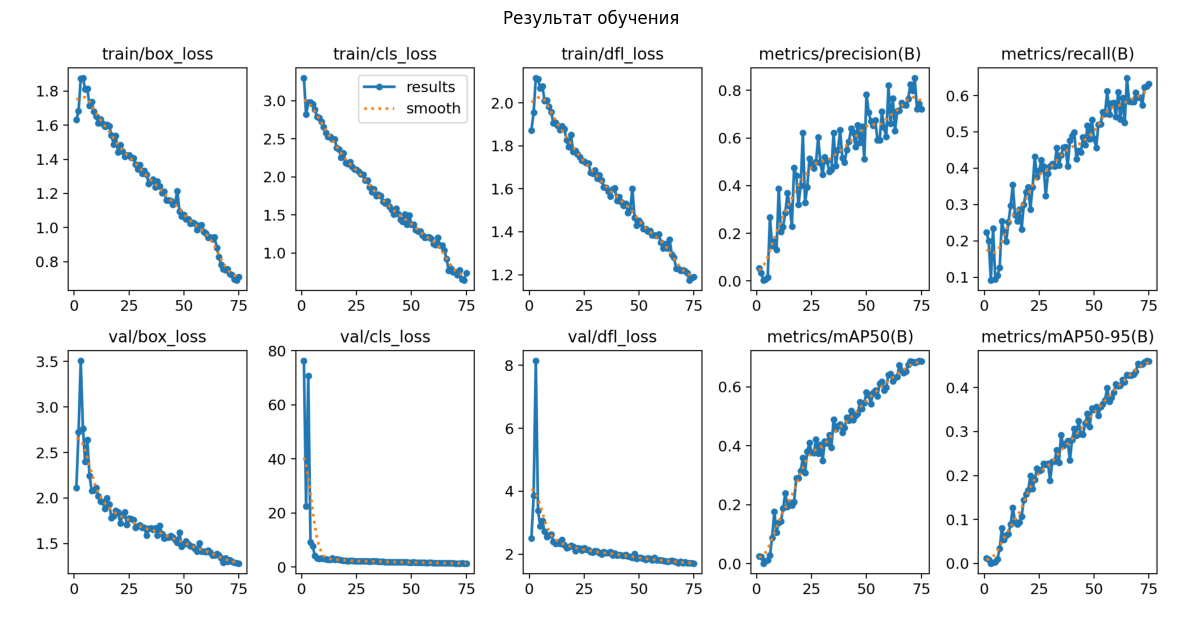

In [ ]:
result_path = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/results.png"

# Результат обучения
img = plt.imread(result_path)
plt.figure(figsize=(15, 8))
plt.title("Результат обучения")
plt.imshow(img)
plt.axis('off')
plt.show()

Выполним небольшой анализ по полученным графикам, описывающие результаты обучения. Модель обучается стабильно и эффективно: все потери уменьшаются, а метрики качества растут. Переобучения пока не наблюдается. Процесс обучения стоит продолжить, так как модель ещё не достигла предела своего потенциала.

## Оценка результатов:

Перейдем к оценке результатов и выведем основные графики, сформировавшиеся после завершения обучения модели. Начнем с *матрицы ошибок*, которых у нас есть 2, а именно: обычная и нормализованная матрицы ошибок. Перейдем к их отображению:

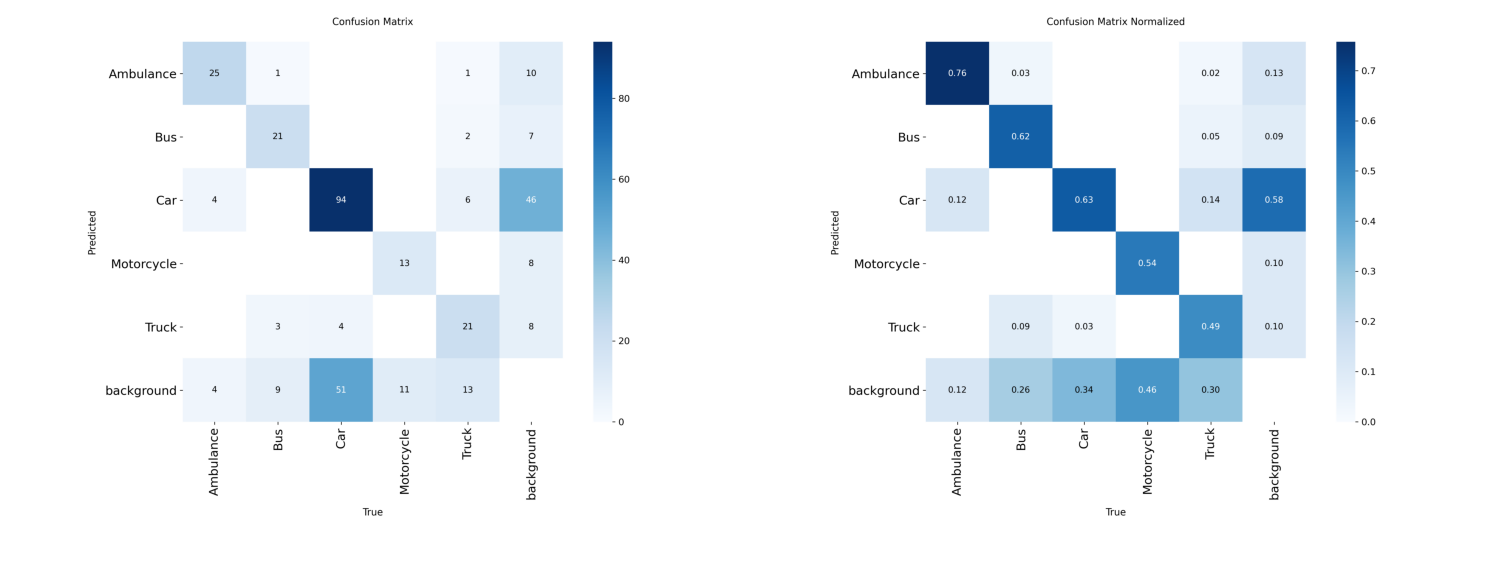

In [ ]:
# Пути к изображениям матриц ошибок (уже определены)
confusion_matrix_path1 = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/confusion_matrix.png"
confusion_matrix_path2 = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/confusion_matrix_normalized.png"

img1 = plt.imread(confusion_matrix_path1)
img2 = plt.imread(confusion_matrix_path2)

# Создаем фигуру с 2 подграфиками (1 строка, 2 столбца)
fig, axes = plt.subplots(1, 2, figsize=(15, 8)) # Увеличиваем ширину для двух изображений

# Первое изображение (обычная матрица ошибок)
axes[0].imshow(img1)
axes[0].axis('off') # Отключаем оси для первого subplot

# Второе изображение (нормализованная матрица ошибок)
axes[1].imshow(img2)
axes[1].axis('off') # Отключаем оси для второго subplot

# Улучшаем расстояние между подграфиками
plt.tight_layout()
# Показываем общую фигуру
plt.show()

Выполним небольшой анализ и 2 графиков матрицы ошибок. Модель демонстрирует хорошее общее качество классификации, но имеет потенциал для улучшения.

Теперь отобразим сразу 4 графиках с кривыми, а именно: **F1-Confidence кривые**, **Precision-Recall кривые**, **Precision-Confidence кривые** и **Recall-Confidence кривые**.

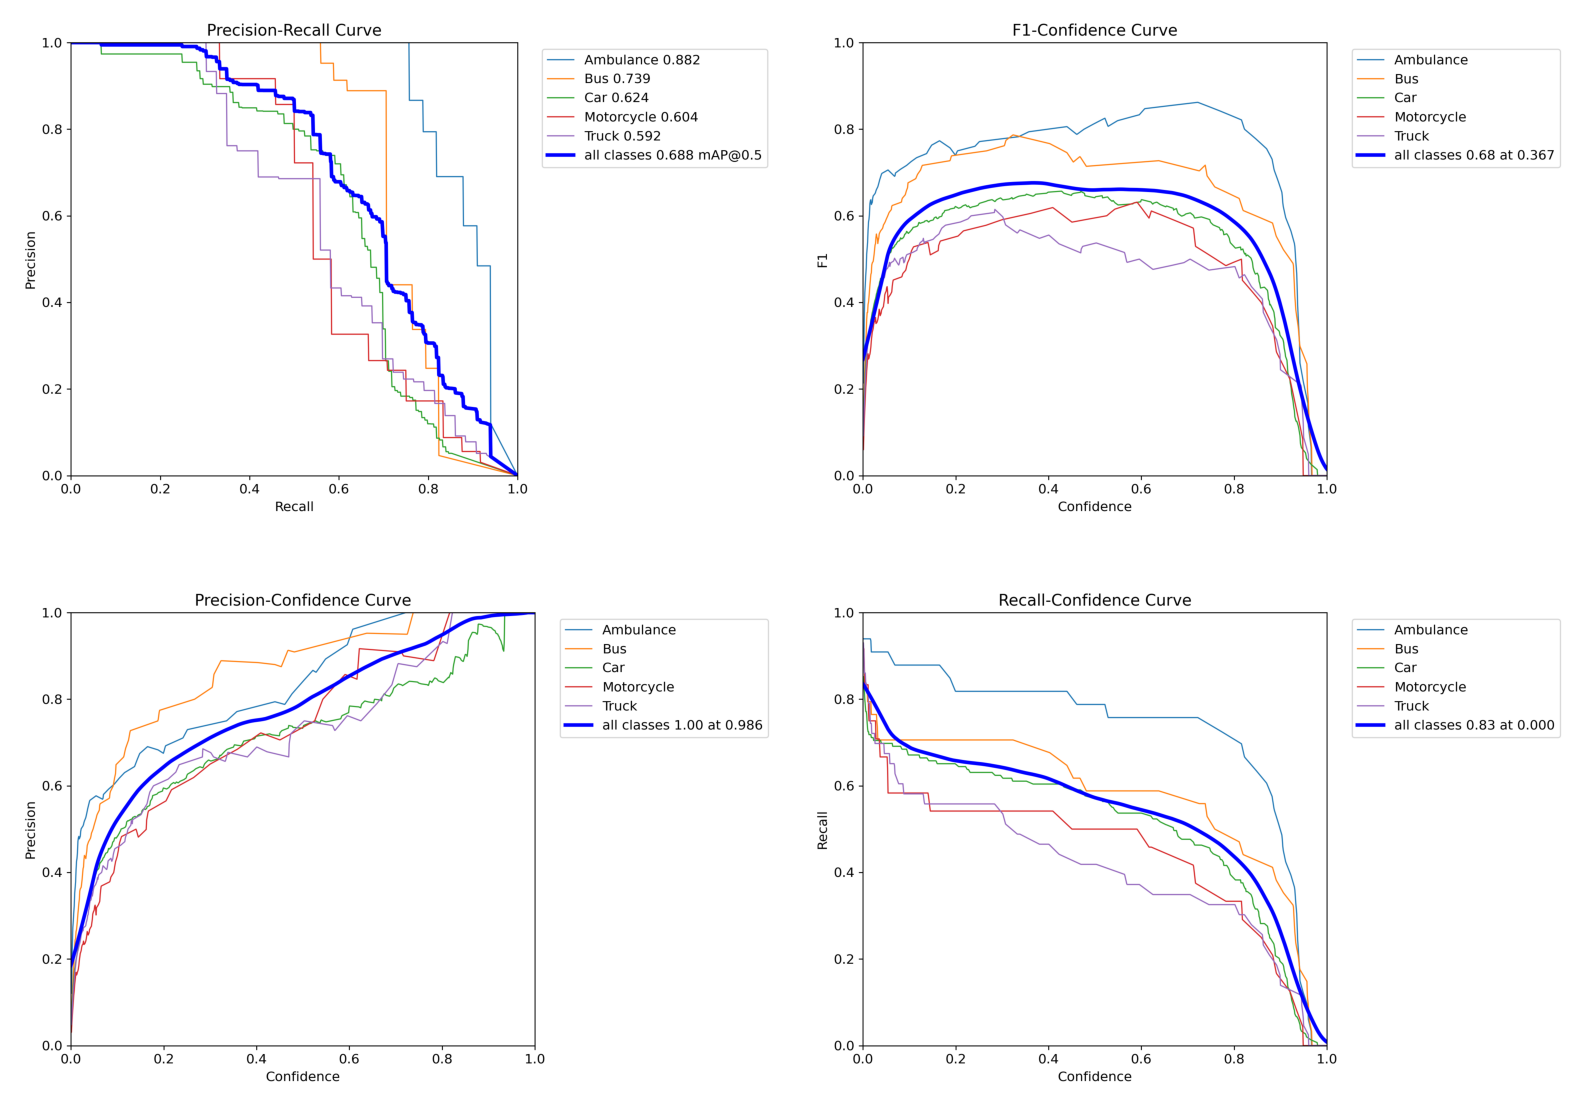

In [ ]:
# Пути к изображениям графиков (уже определены)
PR_curve_path = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/BoxPR_curve.png"
F1_curve_path = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/BoxF1_curve.png"
P_curve_path = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/BoxP_curve.png"
R_curve_path = "/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/BoxR_curve.png"

img_pr = plt.imread(PR_curve_path)
img_f1 = plt.imread(F1_curve_path)
img_p = plt.imread(P_curve_path)
img_r = plt.imread(R_curve_path)

# Создаем фигуру с 4 подграфиками (2 строки, 2 столбца)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].imshow(img_pr)
axes[0, 0].axis('off')

axes[0, 1].imshow(img_f1)
axes[0, 1].axis('off')

axes[1, 0].imshow(img_p)
axes[1, 0].axis('off')

axes[1, 1].imshow(img_r)
axes[1, 1].axis('off')

# Улучшаем расстояние между подграфиками
plt.tight_layout()
# Показываем общую фигуру
plt.show()

Перейдем к финальной оценке графиков, но перед этим определимся, что каждый из них показывает:
*   **Precision-Recall Curve** показывает зависимость точности (**precision**) от полноты (**recall**) при изменении порога уверенности (**confidence threshold**). Чем выше площадь под кривой (AP — Average Precision), тем лучше модель;
*   **F1-Confidence Curve** показывает, как меняется F1-мера (среднее гармоническое precision и recall) при изменении порога уверенности. Пик **F1** указывает на оптимальный порог **confidence**, при котором модель достигает наилучшего баланса между точностью и полнотой;
*   **Precision-Confidence Curve** показывает, как меняется точность (**precision**) при увеличении порога уверенности. Чем выше порог — тем меньше предсказаний, но они более надёжны;
*   **Recall-Confidence Curve** показывает, как меняется полнота (**recall**) при увеличении порога уверенности. Чем выше порог — тем меньше объектов обнаруживается.

Исходя из графиков, можно сделать вывод, что модель готова к использованию, но требует тонкой настройки порога уверенности и целенаправленного улучшения класса "**Car**", чтобы выйти на новый уровень качества.


Для наглядности работы обученной модели давайте реализуем возможность загрузки изображения с компьютера, а также инициализируем модель с лучшими весами:

In [ ]:
best_model = YOLO("/content/drive/MyDrive/MyProject/exp_yolov8n_detect_optimized/weights/best.pt")

# Загрузка файла с компьютера
uploaded = files.upload()

# Получаем имя загруженного файла
uploaded_filename = next(iter(uploaded))

# Открываем и отображаем загруженное изображение
image = Image.open(uploaded_filename)
image.show()

Saving test.jpg to test.jpg


Выполним `predict()` для нашего изображения и получим **BBox (Bounding Box)** и вероятность соответствия для наших объектов:

Results saved to /content/runs/detect/predict
1 label saved to /content/runs/detect/predict/labels


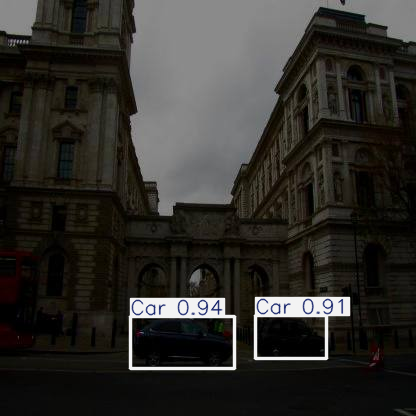

In [ ]:
# Путь к загруженному изображению
test_images_path = f"/content/{uploaded_filename}"

# Получаем результаты предсказания
pred_results_augmentation = best_model.predict(source=test_images_path, save=True, save_txt=True, verbose=False)
for result in pred_results_augmentation:
    result.show()  # Вызываем метод show() для каждого результата

## Выводы:

### Основные результаты:

Код показал хорошие результаты его работы, модель обучилась правильно, все графики выдают адекватные результаты, а выполненное предсказание по своему изображению выдало отличные результаты - 0.94 и 0.91. Несмотря на все это, у модели все ещё присутствует потенциал по её улучшению, но это уже будет компенсироваться мощностью и временем обучения. Таким образом, основная задача этой работы - детекция транспортных средств в условии ограниченной освещенности, была достигнута!

### Проблемы и ограничения:

Из-за нехватки вычислительных мощностей я не могу обучить модель для достижения более высоких результатов. Время, затрачиваемое на обучение модели и выполнение кода, также играет значительную роль. Немало важно и ограниченное использование **графического ускорителя T4** в **Google Colab**, без которого этот код выполнялся бы очень долго.

### Возможные улучшения:

Для улучшения качества работы кода можно использовать графические ускорители, которые мощнее **T4**. Также можно внедрить очистку "мусора", что приведет к небольшой оптимизации кода. Затем можно использовать расширенный набор данных, то есть использовать и аугментированные, и оригинальные данные. Такую функцию я реализовал на уровне кода в виде кнопок. Далее можно подобрать более серьезную версию модели, например, `yolov8l.pt` или `yolov8x.pt`, что потенциально может привести к более качественным результатам, но взамен они будут требовать более мощные вычислительные ресурсы. Можно добавить большее количество эпох для обучения модели, так как явно отсутствует переобучение. Ну и заключительной рекомендацией будет добавление функции предсказания на видео.

## Список источников данных:


1. [Официальная документация компании Ultralytics](https://docs.ultralytics.com/ru/);
2. [Официальная документация модели YOLOv8](https://docs.ultralytics.com/ru/models/yolov8/);
3. [Подробная информация и структура датасета](https://www.kaggle.com/datasets/abdallahwagih/cars-detection/data).